# Compare Powers

In [7]:
# imports
import numpy as np
import pandas as pd
import pickle
import mne
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
############ Powers extracted using MNE ##############
with open('docs/sub-01_powers.pkl', 'rb') as f:
    powers_mne = pickle.load(f)

# Channel names
task = 'baseline1'
path =  f'data/clean_data/sub-01_ses-01_task-{task}_proc-clean_epo.fif'
epochs = mne.read_epochs(path, verbose=False)
ch_names = epochs.ch_names

# average across epochs and convert volts to microvolts
powers_mne_agg = {k:(v * 1000000**2).mean(0) for k, v in powers_mne.items()}

# remove power from M1, M2, and FCz channels
ind = [np.where(np.array(ch_names) == i)[0][0] for i in ['M1', 'M2', 'FCz']]
powers_mne_agg = {k:np.delete(v, ind, axis=0) for k, v in powers_mne_agg.items()}

In [9]:
############ Powers extracted using Fieldtrip ##############
targets = ['01-baseline1',
           '01-experience1', '01-experience2', '01-experience3', '01-experience4',
           '01-baseline2']

# read mat data
mat = loadmat('sessions_power.mat')

# get labels of eeg channels
labels = mat['sessions_power'][0][0][0][0][0]
labels = np.hstack(labels)
labels = [i[0] for i in labels]

# frequencies
freqs = mat['sessions_power'][0][0][0][0][2][0]

# Powers
powers_fieldtrip = {}
for i, cond in enumerate(targets):
    powers_fieldtrip[cond] = mat['sessions_power'][i][0][0][0][3]

del mat

In [10]:
# check if the channel names from MNE and lables from Fieldtrip are the same
# first remove the channels that are not in Fieldtrip labels
[ch_names.remove(i) for i in ['M1', 'M2', 'FCz']]
ch_names == labels

True

## Correlation

In [11]:
# create a pandas dataframe from mne and fieldtrip data
powers_mne_agg_4df = {(k, ch): i for k, v in powers_mne_agg.items() for ch, i in zip(labels, v)}
powers_mne_df = pd.DataFrame(powers_mne_agg_4df)

powers_fieldtrip_4df = {(k, ch): i for k, v in powers_fieldtrip.items() for ch, i in zip(labels, v)}
powers_fieldtrip_df = pd.DataFrame(powers_fieldtrip_4df)

# calculate the correlation between the two dataframes
corr = powers_mne_df.corrwith(powers_fieldtrip_df)


In [ ]:
df = corr.to_frame().reset_index().pivot(index='level_0', columns='level_1')

df.columns = df.columns.droplevel()

df.index = df.reset_index().level_0.apply(lambda x: x.split('-')[1])

df = df.T
fig, ax = plt.subplots(figsize=(7, 18))
# sns.heatmap(df, ax=ax, annot=True, cmap='RdBu', robust=True, cbar_kws={"shrink": 0.5})
sns.clustermap(df, annot=True, cmap='RdBu', robust=True)
ax.set_ylabel('Channels', fontsize=18)
ax.set_xlabel('Conditions', fontsize=18)
ax.set_title('Pearson Correlation', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.show()

## Individual Power Spectrum

ValueError: Per-column arrays must each be 1-dimensional

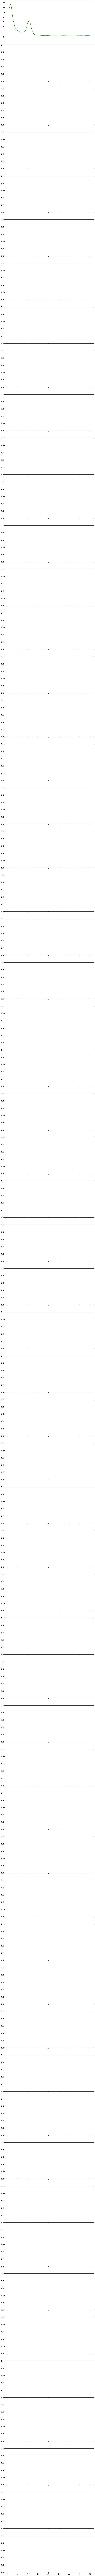

In [17]:
key = '01-baseline1'

fig, axes = plt.subplots(len(labels), 1, sharex= True, figsize = (10, len(labels) * 5))
for i in range(len(powers_fieldtrip[key])):
    sns.lineplot(x=freqs, y=powers_fieldtrip[key][i], color='green', ax=axes[i])
    sns.lineplot(x=freqs, y=powers_mne[key][i], color='purple', ax=axes[i])
    axes[i].set_title(labels[i] ,fontweight='bold', size=15)
    axes[i].set_ylabel('Power (uV^2)/Hz', fontsize=10)
    axes[i].legend(['FieldTrip', 'MNE'], fontsize=10)

plt.show()

## Effect of PSD methods

In [ ]:
from mne.time_frequency import psd_array_welch, psd_welch, psd_multitaper
from mne.time_frequency.tfr import tfr_array_morlet
task = 'baseline1'
path =  f'data/clean_data/sub-01_ses-01_task-{task}_proc-clean_epo.fif'
epochs = mne.read_epochs(path, verbose=False)

# epochs.resample(200)

data = epochs.get_data()
data = np.hstack(data)
# data = np.array(np.split(data, 2, axis=1))

freq = np.arange(1, 42, 1)

n_cycles= np.concatenate([7*np.ones(10),
                6*np.ones(10),
                5*np.ones(10),
                4*np.ones(11)])

psds, freq = psd_array_welch(data,
                            sfreq=1000,
                            # freqs=freq,
                            # n_cycles=5,
                            fmin=1,
                            fmax=40,
                            # output='power',
                            n_fft=2048,
                            n_overlap=0,
                            n_jobs=1)

ch_names = epochs.ch_names
ind = [np.where(np.array(ch_names) == i)[0][0] for i in ['M1', 'M2', 'FCz']]
psds = np.delete(psds, ind, axis=1)

psds2 = (psds * 1000000**2).mean(0)
# psds2 = np.delete(psds2, -1, 1)

Effective window size : 2.048 (s)


In [ ]:
psds2 = (psds * 1000000000000).mean(0)

In [ ]:
powers_mne_agg = {k:(v * 1000000000000).mean(0) for k, v in powers_mne.items()}

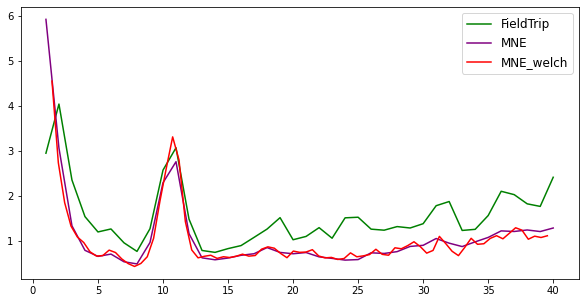

In [ ]:
key = '01-baseline1'

ax, fig = plt.subplots(figsize=(10, 5))
i = np.where(np.array(labels) == 'F7')[0][0]
sns.lineplot(x=freqs, y=powers_fieldtrip[key][i], color='green')
sns.lineplot(x=freqs, y=powers_mne_agg[key][i], color='purple')
sns.lineplot(x=freq, y=psds2[i], color='red')
plt.legend(['FieldTrip', 'MNE', 'MNE_welch'], fontsize=12)

# why is the reason of low frequency resolution? (use morlet methods and visualizeq)
# use morlet methods